##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
import tensorflow as tf
import matplotlib as mpl
import tensorflow_hub as hub
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

Load the pretrained MobileNetV2 model and the ImageNet class names.

In [2]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14548992/14536120 [==============================] - 1s 0us/step


In [3]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Original image

In [4]:
image_path = tf.keras.utils.get_file('red_apple.jpg', 'http://ceclnx01.cec.miamioh.edu/~gaoz15/red_apple.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
print(image.dtype)
image_probs = pretrained_model.predict(image)

40960/31995 [======================================] - 0s 1us/step
<dtype: 'float32'>


Let's have a look at the image.

49152/35363 [=========================================] - 0s 0us/step


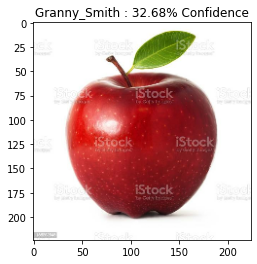

In [5]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the adversarial image

### Implementing fast gradient sign method
The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the image.

In [8]:
loss_object = tf.keras.losses.CategoricalHinge()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  # print(prediction)
  # print(label)
  print(loss)
  # print(gradient)
  return signed_grad

The resulting perturbations can also be visualised.

tf.Tensor(0.7764993, shape=(), dtype=float32)


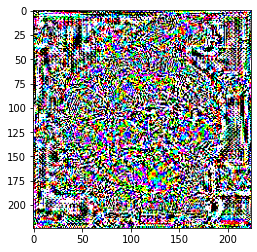

In [9]:
# Get the input label of the image.
labrador_retriever_index = 948
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

Let's try this out for different values of epsilon and observe the resultant image. You'll notice that as the value of epsilon is increased, it becomes easier to fool the network. However, this comes as a trade-off which results in the perturbations becoming more identifiable.

In [ ]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

In [ ]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

## Next steps

Now that you know about adversarial attacks, try this out on different datasets and different architectures. You may also create and train your own model, and then attempt to fool it using the same method. You can also try and see how the confidence in predictions vary as you change epsilon.

Though powerful, the attack shown in this tutorial was just the start of research into adversarial attacks, and there have been multiple papers creating more powerful attacks since then. In addition to adversarial attacks, research has also led to the creation of defenses, which aims at creating robust machine learning models. You may review this [survey paper](https://arxiv.org/abs/1810.00069) for a comprehensive list of adversarial attacks and defences.

For many more implementations of adversarial attacks and defenses, you may want to see the adversarial example library [CleverHans](https://github.com/tensorflow/cleverhans).